## Import

In [1]:
from skimage.io import imread, imshow
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import progressbar
import time
from collections import Counter
import math
import itertools
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Projet/code

/content/drive/MyDrive/Projet/code


# Functions

## Dataset

In [4]:
def getSize(img):
  c=0
  for row in img:
    for pix in row:
      if not math.isnan(pix):
        c+=1
  return c

In [5]:
class Dataset:
  def __init__(self, data, n):
    self.cooc = 0

    # n = size of the co-occurrence matrix
    self.size = len(data['image'])
    self.image = data['image']
    self.cropcode = data['cropcode']
    self.n = n
    self.stats=[]

    # statistics
    # com
    if self.cooc:
      N=256/n
      for img in self.image:
        img = np.asarray(rgb2gray(img[:, :, [3,2,1]]/(2**12))*n, dtype=int)
        row, column = np.shape(img)
        com = np.zeros((n, n), dtype=int)
        for i in range(1, row-1):
          for j in range(1, column-1):
            center = img[i][j]
            if center>0:
              voisins = [(i-1, j-1),(i-1,j),(i-1, j+1), (i,j-1),(i,j+1), (i+1,j-1),(i+1,j),(i+1,j+1)]
              for v in voisins:
                k,l = v
                pixel = img[k][l]
                if pixel>0:
                  com[center][img[k][l]] += 1
        self.stats.append(com)
    else:
      for img in self.image:
        stat_rgba = [getSize(img[:, :, 8]), np.nanmean(img[:, :,3]), np.nanmean(img[:, :,2]), np.nanmean(img[:, :,1]), np.nanmean(img[:, :,8]), np.nanstd(img[:, :,3]), np.nanstd(img[:, :,2]), np.nanstd(img[:, :,1]), np.nanstd(img[:, :,8])]
        self.stats.append(stat_rgba)
    self.stats = np.asarray(self.stats)

    self.stats_train = []
    self.stats_test = []
    self.cropcode_train = []
    self.cropcode_test = []

    copy = self.cropcode
    self.class_names= list(set(copy))

  def print_info(self):
    c = Counter(self.cropcode)
    print("ww = Winter wheat" + '\n' +
          "sb = Spring barley" + '\n' +
          "sw = Spring Wheat" + '\n' +
          "wb = Winter barley" + '\n' +
          "be = Beet (sugar beet / fodder beet)" + '\n' +
          "fb = Field beans" + '\n' +
          "ma = Maize" + '\n' +
          "or = Oilseed rape" + '\n' +
          "po = Potatoes" + '\n' +
          "gr = Grass" + '\n' +
          "ot = Other crops" + '\n' + # i may reject this data
          "pe = Peas" + '\n' +
          "wo = Winter oats")
    key_value = {}
    for i in sorted(c.keys()):
          key_value[i] = c[i]

    plt.bar(key_value.keys(), key_value.values())
    plt.xlabel('Labels')
    plt.ylabel('Occurrence')
    plt.title('Occurrence of crops types')
    plt.show()

  def separate_train_test(self, s):
    # data normalization
    if self.cooc:
      self.stats = self.stats/self.n;
    else :
      self.stats = self.stats/255;

    self.stats_train, self.stats_test, self.cropcode_train, self.cropcode_test = train_test_split(self.stats, self.cropcode, test_size=s)

    print('Size of training set : ' + str(len(self.cropcode_train)) + ' / ' + str(len(self.cropcode)))
    print('Size of testing set : ' + str(len(self.cropcode_test))+ ' / ' + str(len(self.cropcode)))
    self.display_train_test()

  def display_train_test(self):
    test = Counter(self.cropcode_test)
    train = Counter(self.cropcode_train)
    info = "Dataset size " + str(self.size)

    key_value_train = {};
    key_value_test = {};

    for i in sorted(test.keys()):
      key_value_test[i] = test[i]
    for i in sorted(train.keys()):
      key_value_train[i] = train[i]

    p1 = plt.bar(key_value_train.keys(), key_value_train.values(), width=0.5);
    p2 = plt.bar( key_value_test.keys(), key_value_test.values(), width=0.5, bottom=list(key_value_train.values()) );

    plt.legend((p1[0], p2[0]), ('Training set', 'Test set'), loc='lower left')
    plt.xlabel('Labels')
    plt.ylabel('Occurrence')
    plt.title('Occurrence of training and testing sets')
    plt.show()

## Accuracy measure

In [6]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import pandas as pd

def plot_confusion_matrix(cm,
                          target_names=None,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

  if cmap is None:
    cmap = plt.get_cmap('Blues')
  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
      plt.text(j, i, "{:0.3f}".format(cm[i, j]),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")
    else:
      plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

  return cm


def accuracy_metrics(cropcode_true, cropcode_predicted, class_names, data_name):
  conf_mx = confusion_matrix(cropcode_true, cropcode_predicted)

  accuracy = np.trace(conf_mx) / float(np.sum(conf_mx))
  print("Overall Accuracy : {:0.4f}  (misclass ={:0.4f})".format(accuracy, 1-accuracy))
  kappa = cohen_kappa_score(cropcode_true, cropcode_predicted)
  print("Cohen's Coefficient : {:0.4f}".format(kappa))

  k = 0
  d = {}
  for i in class_names:
    t = conf_mx[k, k]
    commision_error = (np.sum(conf_mx[:,k])-t)/np.sum(conf_mx[:,k])
    omission_error = (np.sum(conf_mx[k])-t)/np.sum(conf_mx[k])
    precison = t/np.sum(conf_mx[:,k])
    recall = t/np.sum(conf_mx[k])
    f1 = (2*precison*recall)/(precison+recall)
    d[i] = [commision_error, omission_error, precison, recall, f1]
    k = k+1
  df = pd.DataFrame(data=d, index=["comission error", "omission error", "precison", "recall", "f1"])
  print(df)

  plt.figure(figsize=(10,6))
  conf_mx =  plot_confusion_matrix(cm=conf_mx,
                              target_names= class_names,
                              cmap=plt.cm.Blues,
                              normalize=True)


  with open(data_name+".csv", 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile)
    spamwriter.writerow([''] + class_names)
    i=0
    for n in class_names:
      row = [n]
      for j in conf_mx[i, :]:
        row.append(str(round(j,4)))
      spamwriter.writerow(row)
      i  = i+1

    spamwriter.writerow([''])

    spamwriter.writerow([''] + class_names)
    for m in df.index:
      row = [m]
      for j in df.loc[m]:
        row.append(str(round(j,4)))
      spamwriter.writerow(row)


# Models

## Dataset preparation

In [7]:
# read and create dataset struct
data = np.load("DataSet/data_21_01_jul.npz", allow_pickle=True)
DS = Dataset(data, 16)

ww = Winter wheat
sb = Spring barley
sw = Spring Wheat
wb = Winter barley
be = Beet (sugar beet / fodder beet)
fb = Field beans
ma = Maize
or = Oilseed rape
po = Potatoes
gr = Grass
ot = Other crops
pe = Peas
wo = Winter oats


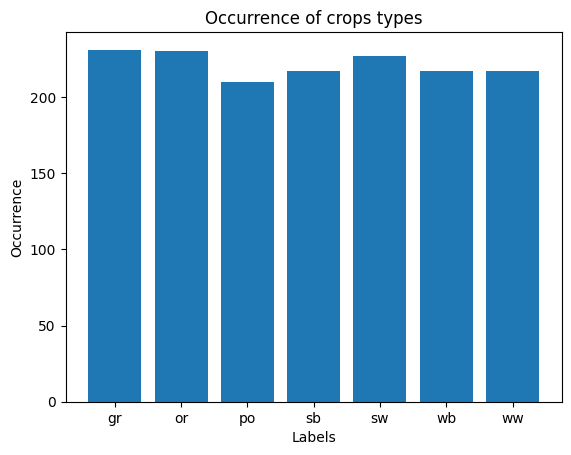

In [8]:
# print info
DS.print_info()

Size of training set : 1239 / 1549
Size of testing set : 310 / 1549


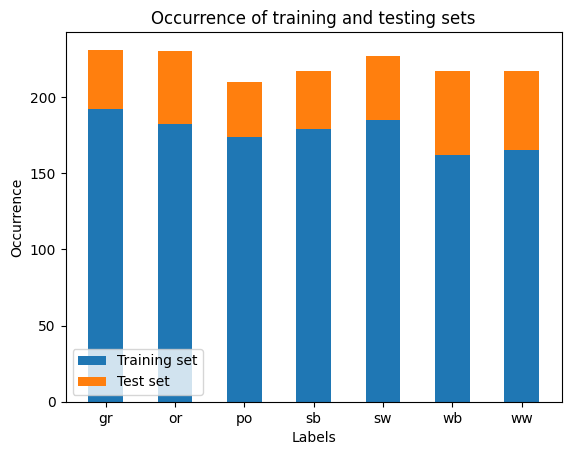

In [9]:
# separate train test
DS.separate_train_test(0.2)

## SVM

In [10]:
from sklearn import svm
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
bar = progressbar.ProgressBar(maxval=len(kernels)).start()
idx = 0;
for ker in kernels:
  print()
  print('Kernel: ' + ker)
  clf = svm.SVC(kernel=ker)
  clf.fit(DS.stats_train, DS.cropcode_train)
  t = time.process_time()
  print( 'processing time : ' + str (round((time.process_time() - t),2)))
  print('Accuracy on training set= ' +  str(round(clf.score(DS.stats_train, DS.cropcode_train),2)));
  print('Accuracy on testing set= ' +  str(round(clf.score(DS.stats_test, DS.cropcode_test),2)));

  idx +=1;
  bar.update(idx)

  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--


Kernel: linear
processing time : 0.0
Accuracy on training set= 0.66


 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:02

Accuracy on testing set= 0.65

Kernel: poly
processing time : 0.0
Accuracy on training set= 0.6


 50% (2 of 4) |#############             | Elapsed Time: 0:00:01 ETA:   0:00:01

Accuracy on testing set= 0.58

Kernel: rbf
processing time : 0.0
Accuracy on training set= 0.57


 75% (3 of 4) |###################       | Elapsed Time: 0:00:02 ETA:   0:00:00

Accuracy on testing set= 0.57

Kernel: sigmoid
processing time : 0.0


100% (4 of 4) |##########################| Elapsed Time: 0:00:02 ETA:  00:00:00

Accuracy on training set= 0.07
Accuracy on testing set= 0.07


Overall Accuracy : 0.6516  (misclass =0.3484)
Cohen's Coefficient : 0.5915
                       po     wb        sw        or        sb        gr  \
comission error  0.480000  0.125  0.375000  0.866667  0.510638  0.135593   
omission error   0.333333  0.125  0.305556  0.947368  0.452381  0.072727   
precison         0.520000  0.875  0.625000  0.133333  0.489362  0.864407   
recall           0.666667  0.875  0.694444  0.052632  0.547619  0.927273   
f1               0.584270  0.875  0.657895  0.075472  0.516854  0.894737   

                       ww  
comission error  0.352941  
omission error   0.365385  
precison         0.647059  
recall           0.634615  
f1               0.640777  


<Figure size 1000x600 with 0 Axes>

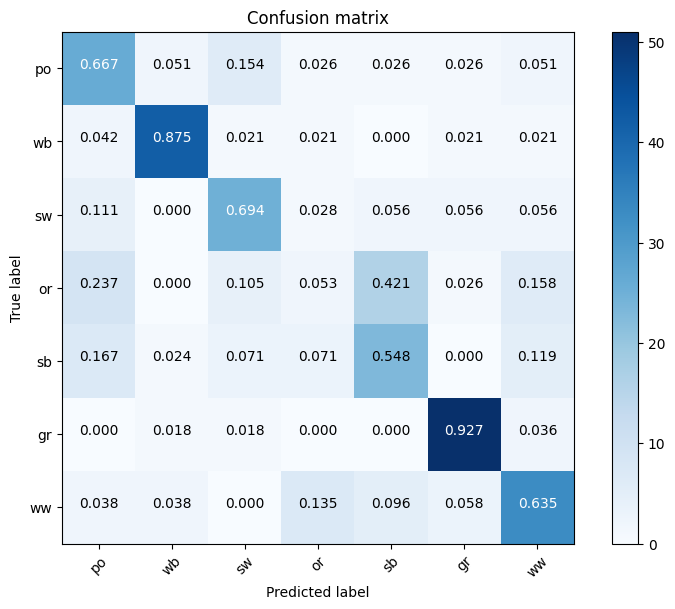

In [11]:
ker = 'linear' #best kernel
clf = svm.SVC(kernel=ker)
clf.fit(DS.stats_train, DS.cropcode_train)
prediction = clf.predict(DS.stats_test)

# confusion matrix and accuracy metrics
accuracy_metrics( DS.cropcode_test, prediction, DS.class_names, 'results/SVM/result_svm_21_01_jul')

## RF


 83% (5 of 6) |#####################     | Elapsed Time: 0:00:00 ETA:  00:00:00

Number of trees of : 1


<Figure size 800x400 with 0 Axes>

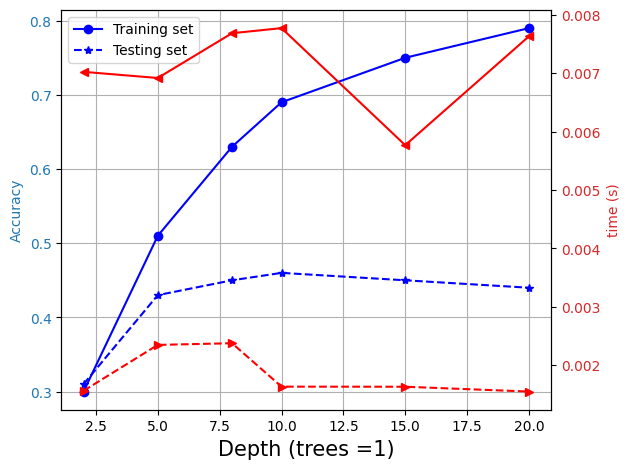

 66% (4 of 6) |#################         | Elapsed Time: 0:00:00 ETA:   0:00:00

Number of trees of : 10


100% (6 of 6) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

<Figure size 800x400 with 0 Axes>

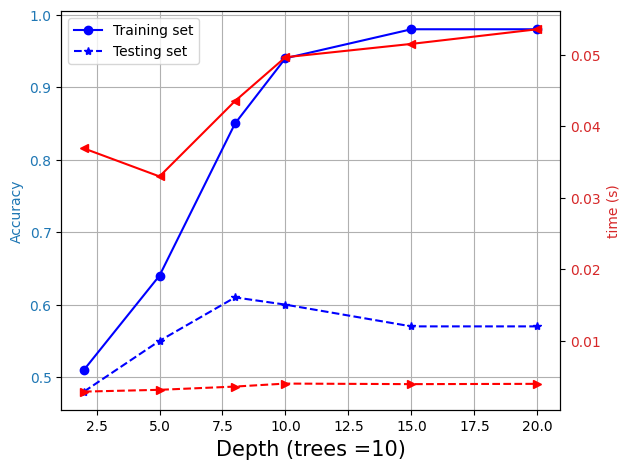

 33% (2 of 6) |########                  | Elapsed Time: 0:00:00 ETA:   0:00:00

Number of trees of : 20


100% (6 of 6) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

<Figure size 800x400 with 0 Axes>

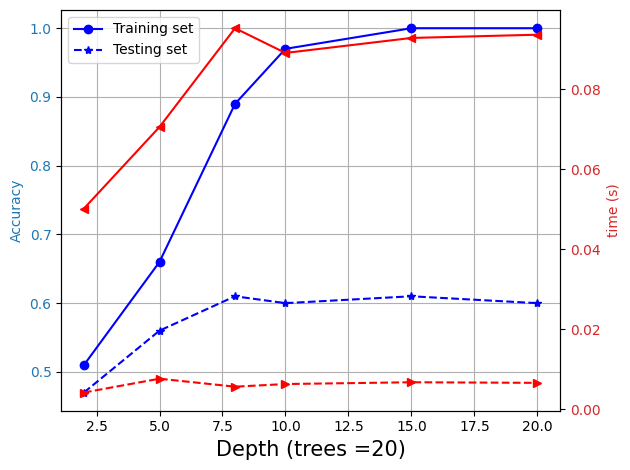

 16% (1 of 6) |####                      | Elapsed Time: 0:00:00 ETA:   0:00:00

Number of trees of : 30


100% (6 of 6) |##########################| Elapsed Time: 0:00:00 ETA:  00:00:00

<Figure size 800x400 with 0 Axes>

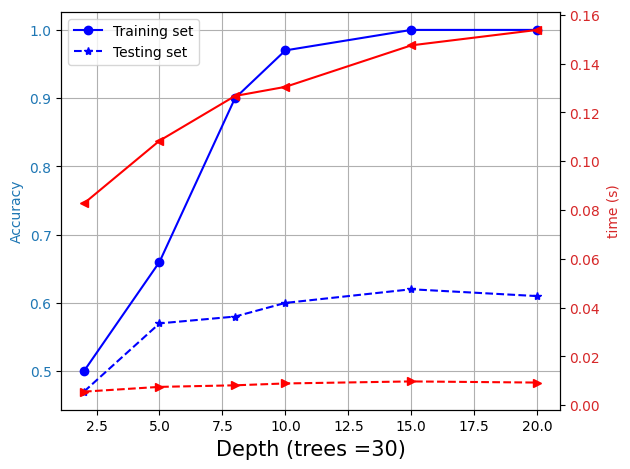

 16% (1 of 6) |####                      | Elapsed Time: 0:00:00 ETA:   0:00:00

Number of trees of : 40


100% (6 of 6) |##########################| Elapsed Time: 0:00:01 ETA:  00:00:00

<Figure size 800x400 with 0 Axes>

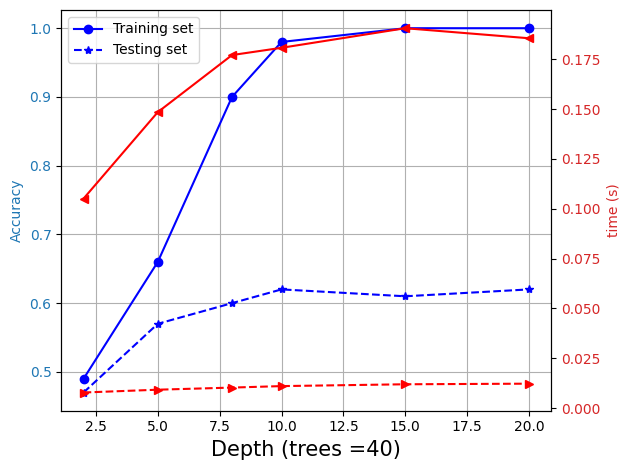

In [12]:
from sklearn.ensemble import RandomForestClassifier

depths = [2,5,8,10,15,20]
trees = [1, 10, 20, 30, 40]


for s in trees:
  idx = 0;
  score_training = [0.0 for i in range(len(depths))]
  score_testing  = [0.0 for i in range(len(depths))]
  time_train  = [0.0 for i in range(len(depths))]
  time_test  = [0.0 for i in range(len(depths))]
  print ("Number of trees of : " + str(s))
  bar = progressbar.ProgressBar(maxval=len(depths)).start()
  for d in depths:
    clf = RandomForestClassifier(max_depth=d, random_state=0, n_estimators=s)
    t = time.process_time()
    clf.fit(DS.stats_train, DS.cropcode_train)
    time_train[idx] = time.process_time() - t
    score_training[idx] = round(clf.score(DS.stats_train, DS.cropcode_train),2);
    time_test[idx] = time.process_time() - t - time_train[idx]
    score_testing[idx] = round(clf.score(DS.stats_test, DS.cropcode_test),2);
    idx +=1;
    bar.update(idx)


  plt.figure(figsize=(8,4))
  fig, ax1 = plt.subplots()

  color = 'tab:blue'
  ax1.set_xlabel('Depth (trees ='+str(s)+')', fontsize=15,)
  ax1.set_ylabel('Accuracy', color=color)
  ax1.plot(depths, score_training, '-bo', label='Training set')
  ax1.plot(depths, score_testing, '--b*', label='Testing set')
  ax1.tick_params(axis='y', labelcolor=color)
  plt.legend(loc='upper left')
  plt.grid()
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  color = 'tab:red'

  ax2.set_ylabel('time (s)', color=color)
  ax2.plot(depths, time_train, '-r<', label='Training set')  # we already handled the x-label with ax1
  ax2.plot(depths, time_test, '--r>', label='Testing set')  # we already handled the x-label with ax1
  ax2.tick_params(axis='y', labelcolor=color)
  fig.tight_layout()  # otherwise the right y-label is slightly clipped

  plt.show()

Overall Accuracy : 0.6097  (misclass =0.3903)
Cohen's Coefficient : 0.5443
                       po        wb        sw        or        sb        gr  \
comission error  0.508772  0.204545  0.468085  0.703704  0.545455  0.096154   
omission error   0.282051  0.270833  0.305556  0.789474  0.523810  0.145455   
precison         0.491228  0.795455  0.531915  0.296296  0.454545  0.903846   
recall           0.717949  0.729167  0.694444  0.210526  0.476190  0.854545   
f1               0.583333  0.760870  0.602410  0.246154  0.465116  0.878505   

                       ww  
comission error  0.333333  
omission error   0.500000  
precison         0.666667  
recall           0.500000  
f1               0.571429  


<Figure size 1000x600 with 0 Axes>

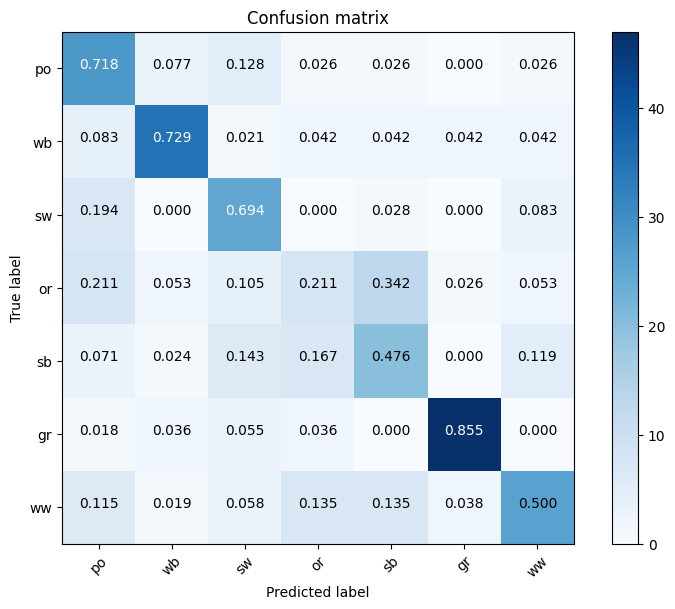

In [13]:
d = 15 # best depth
s = 20 # best number of trees
clf = RandomForestClassifier(max_depth=d, random_state=0, n_estimators=s)
clf.fit(DS.stats_train, DS.cropcode_train)
prediction = clf.predict(DS.stats_test)

# confusion matrix and accuracy metrics
accuracy_metrics( DS.cropcode_test, prediction, DS.class_names,  'results/RF/result_srf_21_01_jul')